C:\Users\visha\AppData\Local\Temp\ipykernel_53680\885012983.py:34: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-dark')
C:\Users\visha\AppData\Local\Temp\ipykernel_53680\885012983.py:40: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = cm.get_cmap('coolwarm')


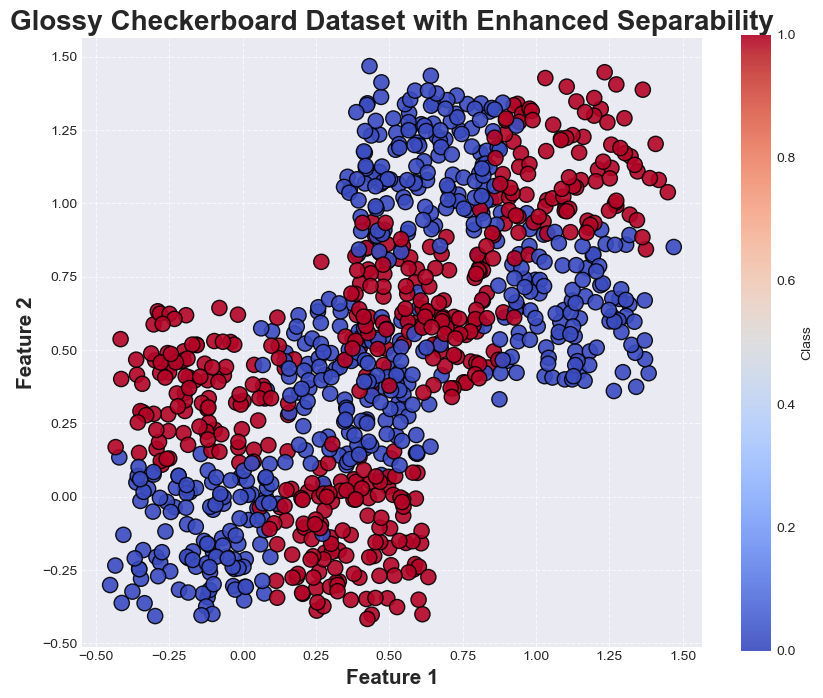

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

def generate_checkerboard_dataset(samples_per_class, classes=2, noise=0.05, separation=0.5):
    np.random.seed(0)
    data = []
    labels = []

    for _ in range(samples_per_class):
        for class_label in range(classes):
            x1 = np.random.rand() + separation * (class_label - 0.5)
            x2 = np.random.rand() + separation * (class_label - 0.5)

            label = int((x1 > 0.5 + separation * (class_label - 0.5)) ^ (x2 > 0.5 + separation * (class_label - 0.5)))
            if class_label == 1:
                label = 1 - label

     
            x1 += np.random.normal(0, noise)
            x2 += np.random.normal(0, noise)

            data.append([x1, x2])
            labels.append(label)

    return np.array(data), np.array(labels)


samples_per_class = 500
data, labels = generate_checkerboard_dataset(samples_per_class, separation=0.75)


plt.style.use('seaborn-dark')


plt.figure(figsize=(10, 8))


colors = cm.get_cmap('coolwarm')


scatter = plt.scatter(data[:, 0], data[:, 1], c=labels, cmap=colors, s=120, edgecolor='k', alpha=0.9)


cbar = plt.colorbar(scatter)
cbar.set_label('Class')


plt.title('Glossy Checkerboard Dataset with Enhanced Separability', fontsize=20, weight='bold')
plt.xlabel('Feature 1', fontsize=15, weight='bold')
plt.ylabel('Feature 2', fontsize=15, weight='bold')


plt.grid(True, linestyle='--', alpha=0.7)


plt.gca().set_aspect('equal', adjustable='box')


plt.show()


In [16]:
import tensorflow as tf
from tensorflow.keras import layers, Sequential
from tensorflow.keras.optimizers import Adam
import numpy as np
from sklearn.model_selection import train_test_split
import csv
import os


class SineActivation(tf.keras.layers.Layer):
    def __init__(self, initial_frequency, **kwargs):
        super().__init__(**kwargs)
        self.initial_frequency = initial_frequency
    
    def build(self, input_shape):
        self.freq = self.add_weight(shape=(), 
                                    initializer=tf.keras.initializers.Constant(self.initial_frequency),
                                    trainable=True, 
                                    name='freq')
    
    def call(self, inputs):
        return tf.math.sin(self.freq * inputs)


def generate_checkerboard_dataset(samples_per_class, classes=2, noise=0.05, separation=0.5):
    np.random.seed(0)
    data = []
    labels = []

    for _ in range(samples_per_class):
        for class_label in range(classes):
            x1 = np.random.rand() + separation * (class_label - 0.5)
            x2 = np.random.rand() + separation * (class_label - 0.5)

       
            label = int((x1 > 0.5 + separation * (class_label - 0.5)) ^ (x2 > 0.5 + separation * (class_label - 0.5)))
            if class_label == 1:
                label = 1 - label


            x1 += np.random.normal(0, noise)
            x2 += np.random.normal(0, noise)

            data.append([x1, x2])
            labels.append(label)

    return np.array(data), np.array(labels)


samples_per_class = 500
X, y = generate_checkerboard_dataset(samples_per_class, separation=0.75)

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

def create_model(activation, hidden_units, k_values, initializer):
    model = Sequential([layers.Input(shape=(2,))])
    
    sine_layers_k = []  
    for i, units in enumerate(hidden_units):
        if (activation == 'sine'):
            dense_layer = layers.Dense(units, 
                                       kernel_initializer=initializer, 
                                       bias_initializer=initializer, 
                                       name=f'dense_{i}')
            model.add(dense_layer)
            sine_activation_layer = SineActivation(initial_frequency=k_values[i], name=f'sine_{i}')
            model.add(sine_activation_layer)
            sine_layers_k.append(sine_activation_layer)
        else:
            model.add(layers.Dense(units, 
                                   activation=activation, 
                                   kernel_initializer=initializer, 
                                   bias_initializer=initializer, 
                                   name=f'dense_{i}'))
    
    model.add(layers.Dense(1, 
                           activation='sigmoid', 
                           kernel_initializer=initializer, 
                           bias_initializer=initializer, 
                           name='output'))
    return model, sine_layers_k


def train_step(model, x_batch, y_batch, optimizer_main, optimizer_k):
    with tf.GradientTape() as tape:
        predictions = model(x_batch, training=True)
        y_batch = tf.reshape(y_batch, (-1, 1))
        loss = tf.keras.losses.binary_crossentropy(y_batch, predictions)
        loss = tf.reduce_mean(loss) 
    
    grads = tape.gradient(loss, model.trainable_variables)
    
    k_vars = [v for v in model.trainable_variables if 'freq' in v.name]
    other_vars = [v for v in model.trainable_variables if 'freq' not in v.name]
    
    k_grads = [g for g, v in zip(grads, model.trainable_variables) if 'freq' in v.name]
    other_grads = [g for g, v in zip(grads, model.trainable_variables) if 'freq' not in v.name]
    
    optimizer_k.apply_gradients(zip(k_grads, k_vars))
    optimizer_main.apply_gradients(zip(other_grads, other_vars))
    
    return loss

def run_experiment(initializer_name, initializer):
    H = [32, 16]
    K = [1.6, 1.6]  
    learning_rate_main = 0.001
    learning_rate_k = 0.01
    epochs = 30
    batch_size = 32

    # Create model
    model, sine_layers_k = create_model('sine', H, K, initializer)

    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Create separate optimizers
    optimizer_main = Adam(learning_rate=learning_rate_main)
    optimizer_k = Adam(learning_rate=learning_rate_k)

    for epoch in range(epochs):
        total_loss = 0.0
        num_batches = 0
        for i in range(0, len(X_train), batch_size):
            x_batch = X_train[i:i+batch_size]
            y_batch = y_train[i:i+batch_size]
            
            batch_loss = train_step(model, x_batch, y_batch, optimizer_main, optimizer_k)
            total_loss += batch_loss.numpy()
            num_batches += 1
        
        avg_loss = total_loss / num_batches
        
        if epoch % 10 == 0:
            test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
            print(f"Initializer: {initializer_name}, Epoch {epoch+1}/{epochs}, Avg Loss: {avg_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
    print(f"Initializer: {initializer_name}, Final Test Accuracy: {test_accuracy:.4f}")

    num_params = model.count_params()
    
    save_results_to_csv(
        test_accuracy=test_accuracy,
        num_params=num_params,
        activation='sine',
        initializer=initializer_name,
        dataset_name='Checkerboard'
    )
    
    for i, layer in enumerate(sine_layers_k):
        print(f"Initializer: {initializer_name}, Layer {i+1} - Initial k: {K[i]}, Final k: {layer.freq.numpy():.4f}")
    
    return test_accuracy

def save_results_to_csv(test_accuracy, num_params, activation, initializer, dataset_name):
    csv_filename = 'experiment_results.csv'
    headers = ['Test Accuracy', 'Number of Parameters', 'Activation', 'Initializer', 'Dataset']

    row = [test_accuracy, num_params, activation, initializer, dataset_name]

    file_exists = os.path.isfile(csv_filename)
    
    with open(csv_filename, mode='a', newline='') as file:
        writer = csv.writer(file)
        
        if not file_exists:
            writer.writerow(headers)
        
        writer.writerow(row)


initializers = {
    'xavier': tf.keras.initializers.GlorotUniform(),
    'he': tf.keras.initializers.HeNormal(),
    'lecun': tf.keras.initializers.LecunUniform(),
    'random': tf.keras.initializers.RandomUniform(minval=-1.5, maxval=1.5),
    'uniform': tf.keras.initializers.RandomUniform(minval=-1.5, maxval=1.5)
}


results = {}
for name, initializer in initializers.items():
    print(f"\nRunning experiment with {name} initializer...")
    accuracy = run_experiment(name, initializer)
    results[name] = accuracy

print("\nSummary of Results:")
for name, accuracy in results.items():
    print(f"{name} initializer: {accuracy:.4f}")

best_initializer = max(results, key=results.get)
print(f"\nBest initializer: {best_initializer} with accuracy {results[best_initializer]:.4f}")



Running experiment with xavier initializer...
Initializer: xavier, Epoch 1/30, Avg Loss: 0.8130, Test Accuracy: 0.5550
Initializer: xavier, Epoch 11/30, Avg Loss: 0.5538, Test Accuracy: 0.8200
Initializer: xavier, Epoch 21/30, Avg Loss: 0.4046, Test Accuracy: 0.7950
Initializer: xavier, Final Test Accuracy: 0.8200
Initializer: xavier, Layer 1 - Initial k: 1.6, Final k: 3.0379
Initializer: xavier, Layer 2 - Initial k: 1.6, Final k: 2.8432

Running experiment with he initializer...
Initializer: he, Epoch 1/30, Avg Loss: 0.7280, Test Accuracy: 0.5800
Initializer: he, Epoch 11/30, Avg Loss: 0.3231, Test Accuracy: 0.8350
Initializer: he, Epoch 21/30, Avg Loss: 0.2881, Test Accuracy: 0.8650
Initializer: he, Final Test Accuracy: 0.8700
Initializer: he, Layer 1 - Initial k: 1.6, Final k: 1.6518
Initializer: he, Layer 2 - Initial k: 1.6, Final k: 2.1005

Running experiment with lecun initializer...
Initializer: lecun, Epoch 1/30, Avg Loss: 0.7924, Test Accuracy: 0.5350
Initializer: lecun, Epoc

In [18]:
import tensorflow as tf
from tensorflow.keras import layers, Sequential
from tensorflow.keras.optimizers import Adam
import numpy as np
from sklearn.model_selection import train_test_split
import csv
import os


def mish(x):
    return x * tf.math.tanh(tf.math.softplus(x))


def generate_checkerboard_dataset(samples_per_class, classes=2, noise=0.05, separation=0.5):
    np.random.seed(0)
    data = []
    labels = []

    for _ in range(samples_per_class):
        for class_label in range(classes):
            x1 = np.random.rand() + separation * (class_label - 0.5)
            x2 = np.random.rand() + separation * (class_label - 0.5)


            label = int((x1 > 0.5 + separation * (class_label - 0.5)) ^ (x2 > 0.5 + separation * (class_label - 0.5)))
            if class_label == 1:
                label = 1 - label


            x1 += np.random.normal(0, noise)
            x2 += np.random.normal(0, noise)

            data.append([x1, x2])
            labels.append(label)

    return np.array(data), np.array(labels)


samples_per_class = 500
X, y = generate_checkerboard_dataset(samples_per_class, separation=0.75)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

def create_model(activation, hidden_units, initializer):
    model = Sequential([layers.Input(shape=(2,))])
    
    for i, units in enumerate(hidden_units):
        model.add(layers.Dense(units, 
                               kernel_initializer=initializer, 
                               bias_initializer=initializer, 
                               name=f'dense_{i}'))
        if activation == 'mish':
            model.add(layers.Activation(mish))
        else:
            model.add(layers.Activation(activation))
    
    model.add(layers.Dense(1, 
                           activation='sigmoid', 
                           kernel_initializer=initializer, 
                           bias_initializer=initializer, 
                           name='output'))
    return model

def run_experiment(activation, initializer_name, initializer, dataset_name):

    H = [32,16]
    learning_rate = 0.001
    epochs = 30
    batch_size = 32


    model = create_model(activation, H, initializer)

    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])


    history = model.fit(X_train, y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_split=0.2,
                        verbose=0)

    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
    num_params = model.count_params()
    
    print(f"Activation: {activation}, Initializer: {initializer_name}, Final Test Accuracy: {test_accuracy:.4f}, Num Params: {num_params}")
    

    save_results_to_csv(test_accuracy, num_params, activation, initializer_name, dataset_name)
    
    return test_accuracy

def save_results_to_csv(test_accuracy, num_params, activation, weight_init, dataset):
    csv_filename = 'experiment_results.csv'
    headers = ['test_accuracy', 'num_params', 'activation', 'weight_init', 'dataset']

    row = [test_accuracy, num_params, activation, weight_init, dataset]

    file_exists = os.path.isfile(csv_filename)
    
    with open(csv_filename, mode='a', newline='') as file:
        writer = csv.writer(file)
        
        if not file_exists:
            writer.writerow(headers)
        
        writer.writerow(row)


activations = ['relu', 'leaky_relu', 'elu', 'softplus', 'swish', 'mish', 'gelu']
initializers = {
    'xavier': tf.keras.initializers.GlorotUniform(),
    'he': tf.keras.initializers.HeNormal(),
    'lecun': tf.keras.initializers.LecunUniform(),
    'random': tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05),
    'uniform': tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05)
}


dataset_name = 'Checkerboard'


results = {}
for activation in activations:
    for init_name, initializer in initializers.items():
        print(f"\nRunning experiment with {activation} activation and {init_name} initializer...")
        accuracy = run_experiment(activation, init_name, initializer, dataset_name)
        results[(activation, init_name)] = accuracy


print("\nSummary of Results:")
for (activation, init_name), accuracy in results.items():
    print(f"{activation} activation with {init_name} initializer: {accuracy:.4f}")


best_combo = max(results, key=results.get)
print(f"\nBest combination: {best_combo[0]} activation with {best_combo[1]} initializer, accuracy: {results[best_combo]:.4f}")



Running experiment with relu activation and xavier initializer...
Activation: relu, Initializer: xavier, Final Test Accuracy: 0.6600, Num Params: 641

Running experiment with relu activation and he initializer...
Activation: relu, Initializer: he, Final Test Accuracy: 0.6900, Num Params: 641

Running experiment with relu activation and lecun initializer...
Activation: relu, Initializer: lecun, Final Test Accuracy: 0.7550, Num Params: 641

Running experiment with relu activation and random initializer...
Activation: relu, Initializer: random, Final Test Accuracy: 0.5900, Num Params: 641

Running experiment with relu activation and uniform initializer...
Activation: relu, Initializer: uniform, Final Test Accuracy: 0.5900, Num Params: 641

Running experiment with leaky_relu activation and xavier initializer...
Activation: leaky_relu, Initializer: xavier, Final Test Accuracy: 0.6150, Num Params: 641

Running experiment with leaky_relu activation and he initializer...
Activation: leaky_rel

C:\Users\visha\AppData\Local\Temp\ipykernel_53680\1224856005.py:49: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-dark')
C:\Users\visha\AppData\Local\Temp\ipykernel_53680\1224856005.py:55: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = cm.get_cmap('viridis', 3)


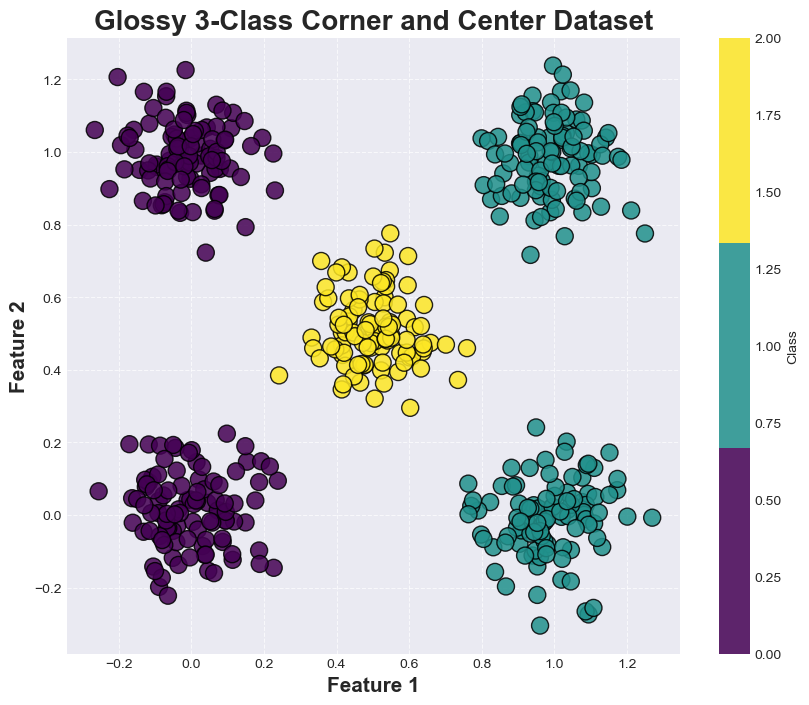

In [38]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

def generate_corner_and_center_dataset(samples_per_class, noise=0.1):
    np.random.seed(0)
    data = []
    labels = []

  
    group1_corners = [(0, 0), (0, 1)]  
    group2_corners = [(1, 0), (1, 1)] 
    center = [(0.5, 0.5)]  
    
  
    for corner in group1_corners:
        x1_corner, x2_corner = corner
        for _ in range(samples_per_class):
            x1 = x1_corner + np.random.normal(0, noise)
            x2 = x2_corner + np.random.normal(0, noise)
            data.append([x1, x2])
            labels.append(0)  
    
   
    for corner in group2_corners:
        x1_corner, x2_corner = corner
        for _ in range(samples_per_class):
            x1 = x1_corner + np.random.normal(0, noise)
            x2 = x2_corner + np.random.normal(0, noise)
            data.append([x1, x2])
            labels.append(1) 
    
 
    for center_point in center:
        x1_center, x2_center = center_point
        for _ in range(samples_per_class):
            x1 = x1_center + np.random.normal(0, noise)
            x2 = x2_center + np.random.normal(0, noise)
            data.append([x1, x2])
            labels.append(2) 

    return np.array(data), np.array(labels)


samples_per_class = 100
data, labels = generate_corner_and_center_dataset(samples_per_class)


plt.style.use('seaborn-dark')


plt.figure(figsize=(10, 8))


colors = cm.get_cmap('viridis', 3)


scatter = plt.scatter(data[:, 0], data[:, 1], c=labels, cmap=colors, s=150, edgecolor='k', alpha=0.85)


cbar = plt.colorbar(scatter)
cbar.set_label('Class')


plt.title('Glossy 3-Class Corner and Center Dataset', fontsize=20, weight='bold')
plt.xlabel('Feature 1', fontsize=15, weight='bold')
plt.ylabel('Feature 2', fontsize=15, weight='bold')


plt.grid(True, linestyle='--', alpha=0.7)


plt.gca().set_aspect('equal', adjustable='box')


plt.show()


In [41]:
import tensorflow as tf
from tensorflow.keras import layers, Sequential
from tensorflow.keras.optimizers import Adam
import numpy as np
from sklearn.model_selection import train_test_split
import csv
import os


class SineActivation(tf.keras.layers.Layer):
    def __init__(self, initial_frequency, **kwargs):
        super().__init__(**kwargs)
        self.initial_frequency = initial_frequency
    
    def build(self, input_shape):
        self.freq = self.add_weight(shape=(), 
                                    initializer=tf.keras.initializers.Constant(self.initial_frequency),
                                    trainable=True, 
                                    name='freq')
    
    def call(self, inputs):
        return tf.math.sin(self.freq * inputs)


def generate_corner_and_center_dataset(samples_per_class, noise=0.1):
    np.random.seed(0)
    data = []
    labels = []


    group1_corners = [(0, 0), (0, 1)]  
    group2_corners = [(1, 0), (1, 1)]  
    center = [(0.5, 0.5)]  
    
   
    for corner in group1_corners:
        x1_corner, x2_corner = corner
        for _ in range(samples_per_class):
            x1 = x1_corner + np.random.normal(0, noise)
            x2 = x2_corner + np.random.normal(0, noise)
            data.append([x1, x2])
            labels.append(0) 
    
  
    for corner in group2_corners:
        x1_corner, x2_corner = corner
        for _ in range(samples_per_class):
            x1 = x1_corner + np.random.normal(0, noise)
            x2 = x2_corner + np.random.normal(0, noise)
            data.append([x1, x2])
            labels.append(1) 
    
   
    for center_point in center:
        x1_center, x2_center = center_point
        for _ in range(samples_per_class):
            x1 = x1_center + np.random.normal(0, noise)
            x2 = x2_center + np.random.normal(0, noise)
            data.append([x1, x2])
            labels.append(2)  

    return np.array(data), np.array(labels)


samples_per_class = 100
X, y = generate_corner_and_center_dataset(samples_per_class)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

def create_model(activation, hidden_units, k_values, initializer):
    model = Sequential([layers.Input(shape=(2,))])
    
    sine_layers_k = [] 
    for i, units in enumerate(hidden_units):
        if activation == 'sine':
            dense_layer = layers.Dense(units, 
                                       kernel_initializer=initializer, 
                                       bias_initializer=initializer, 
                                       name=f'dense_{i}')
            model.add(dense_layer)
            sine_activation_layer = SineActivation(initial_frequency=k_values[i], name=f'sine_{i}')
            model.add(sine_activation_layer)
            sine_layers_k.append(sine_activation_layer)
        else:
            model.add(layers.Dense(units, 
                                   activation=activation, 
                                   kernel_initializer=initializer, 
                                   bias_initializer=initializer, 
                                   name=f'dense_{i}'))
    
    model.add(layers.Dense(3, 
                           activation='softmax', 
                           kernel_initializer=initializer, 
                           bias_initializer=initializer, 
                           name='output'))
    return model, sine_layers_k


def train_step(model, x_batch, y_batch, optimizer_main, optimizer_k):
    with tf.GradientTape() as tape:
        predictions = model(x_batch, training=True)
        y_batch = tf.reshape(y_batch, (-1, 1))
        loss = tf.keras.losses.sparse_categorical_crossentropy(y_batch, predictions)
        loss = tf.reduce_mean(loss) 
    
    grads = tape.gradient(loss, model.trainable_variables)
    
    k_vars = [v for v in model.trainable_variables if 'freq' in v.name]
    other_vars = [v for v in model.trainable_variables if 'freq' not in v.name]
    
    k_grads = [g for g, v in zip(grads, model.trainable_variables) if 'freq' in v.name]
    other_grads = [g for g, v in zip(grads, model.trainable_variables) if 'freq' not in v.name]
    
    optimizer_k.apply_gradients(zip(k_grads, k_vars))
    optimizer_main.apply_gradients(zip(other_grads, other_vars))
    
    return loss

def run_experiment(initializer_name, initializer):
    H = [1]
    K = [1.6] 
    learning_rate_main = 0.01
    learning_rate_k = 0.01
    epochs = 30
    batch_size = 32

    # Create model
    model, sine_layers_k = create_model('sine', H, K, initializer)

    # Compile the model
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Create separate optimizers
    optimizer_main = Adam(learning_rate=learning_rate_main)
    optimizer_k = Adam(learning_rate=learning_rate_k)

    for epoch in range(epochs):
        total_loss = 0.0
        num_batches = 0
        for i in range(0, len(X_train), batch_size):
            x_batch = X_train[i:i+batch_size]
            y_batch = y_train[i:i+batch_size]
            
            batch_loss = train_step(model, x_batch, y_batch, optimizer_main, optimizer_k)
            total_loss += batch_loss.numpy()
            num_batches += 1
        
        avg_loss = total_loss / num_batches
        
        if epoch % 10 == 0:
            test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
            print(f"Initializer: {initializer_name}, Epoch {epoch+1}/{epochs}, Avg Loss: {avg_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
    print(f"Initializer: {initializer_name}, Final Test Accuracy: {test_accuracy:.4f}")

    num_params = model.count_params()
    
    save_results_to_csv(
        test_accuracy=test_accuracy,
        num_params=num_params,
        activation='sine',
        initializer=initializer_name,
        dataset_name='Corner and Center'
    )
    
    for i, layer in enumerate(sine_layers_k):
        print(f"Initializer: {initializer_name}, Layer {i+1} - Initial k: {K[i]}, Final k: {layer.freq.numpy():.4f}")
    
    return test_accuracy

def save_results_to_csv(test_accuracy, num_params, activation, initializer, dataset_name):
    csv_filename = 'experiment_results.csv'
    headers = ['Test Accuracy', 'Number of Parameters', 'Activation', 'Initializer', 'Dataset']

    row = [test_accuracy, num_params, activation, initializer, dataset_name]

    file_exists = os.path.isfile(csv_filename)
    
    with open(csv_filename, mode='a', newline='') as file:
        writer = csv.writer(file)
        
        if not file_exists:
            writer.writerow(headers)
        
        writer.writerow(row)

# Define initializers
initializers = {
    'xavier': tf.keras.initializers.GlorotUniform(),
    'he': tf.keras.initializers.HeNormal(),
    'lecun': tf.keras.initializers.LecunUniform(),
    'random': tf.keras.initializers.RandomUniform(minval=-1.5, maxval=1.5),
    'uniform': tf.keras.initializers.RandomUniform(minval=-1.5, maxval=1.5)
}

# Run experiments for each initializer
results = {}
for name, initializer in initializers.items():
    print(f"\nRunning experiment with {name} initializer...")
    accuracy = run_experiment(name, initializer)
    results[name] = accuracy

print("\nSummary of Results:")
for name, accuracy in results.items():
    print(f"{name} initializer: {accuracy:.4f}")

best_initializer = max(results, key=results.get)
print(f"\nBest initializer: {best_initializer} with accuracy {results[best_initializer]:.4f}")



Running experiment with xavier initializer...
Initializer: xavier, Epoch 1/30, Avg Loss: 0.8790, Test Accuracy: 0.7600
Initializer: xavier, Epoch 11/30, Avg Loss: 0.4259, Test Accuracy: 0.7600
Initializer: xavier, Epoch 21/30, Avg Loss: 0.3258, Test Accuracy: 0.8400
Initializer: xavier, Final Test Accuracy: 0.9300
Initializer: xavier, Layer 1 - Initial k: 1.6, Final k: 1.8068

Running experiment with he initializer...
Initializer: he, Epoch 1/30, Avg Loss: 1.1958, Test Accuracy: 0.2700
Initializer: he, Epoch 11/30, Avg Loss: 0.8792, Test Accuracy: 0.6200
Initializer: he, Epoch 21/30, Avg Loss: 0.3307, Test Accuracy: 0.8100
Initializer: he, Final Test Accuracy: 0.9200
Initializer: he, Layer 1 - Initial k: 1.6, Final k: 2.7450

Running experiment with lecun initializer...
Initializer: lecun, Epoch 1/30, Avg Loss: 1.4255, Test Accuracy: 0.5000
Initializer: lecun, Epoch 11/30, Avg Loss: 0.4568, Test Accuracy: 0.7600
Initializer: lecun, Epoch 21/30, Avg Loss: 0.3473, Test Accuracy: 0.7700


In [42]:
import tensorflow as tf
from tensorflow.keras import layers, Sequential
from tensorflow.keras.optimizers import Adam
import numpy as np
from sklearn.model_selection import train_test_split
import csv
import os


def mish(x):
    return x * tf.math.tanh(tf.math.softplus(x))

def generate_corner_and_center_dataset(samples_per_class, noise=0.1):
    np.random.seed(0)
    data = []
    labels = []

  
    group1_corners = [(0, 0), (0, 1)]  
    group2_corners = [(1, 0), (1, 1)]  
    center = [(0.5, 0.5)]  
    

    for corner in group1_corners:
        x1_corner, x2_corner = corner
        for _ in range(samples_per_class):
            x1 = x1_corner + np.random.normal(0, noise)
            x2 = x2_corner + np.random.normal(0, noise)
            data.append([x1, x2])
            labels.append(0) 
    

    for corner in group2_corners:
        x1_corner, x2_corner = corner
        for _ in range(samples_per_class):
            x1 = x1_corner + np.random.normal(0, noise)
            x2 = x2_corner + np.random.normal(0, noise)
            data.append([x1, x2])
            labels.append(1) 
    

    for center_point in center:
        x1_center, x2_center = center_point
        for _ in range(samples_per_class):
            x1 = x1_center + np.random.normal(0, noise)
            x2 = x2_center + np.random.normal(0, noise)
            data.append([x1, x2])
            labels.append(2) 

    return np.array(data), np.array(labels)


samples_per_class = 100
X, y = generate_corner_and_center_dataset(samples_per_class)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

def create_model(activation, hidden_units, initializer):
    model = Sequential([layers.Input(shape=(2,))])
    
    for i, units in enumerate(hidden_units):
        model.add(layers.Dense(units, 
                               kernel_initializer=initializer, 
                               bias_initializer=initializer, 
                               name=f'dense_{i}'))
        if activation == 'mish':
            model.add(layers.Activation(mish))
        else:
            model.add(layers.Activation(activation))
    

    model.add(layers.Dense(3, 
                           activation='softmax', 
                           kernel_initializer=initializer, 
                           bias_initializer=initializer, 
                           name='output'))
    return model

def run_experiment(activation, initializer_name, initializer, dataset_name):
 
    H = [1]
    learning_rate = 0.01
    epochs = 30
    batch_size = 32


    model = create_model(activation, H, initializer)


    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    history = model.fit(X_train, y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_split=0.2,
                        verbose=0)

    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
    num_params = model.count_params()
    
    print(f"Activation: {activation}, Initializer: {initializer_name}, Final Test Accuracy: {test_accuracy:.4f}, Num Params: {num_params}")

    save_results_to_csv(test_accuracy, num_params, activation, initializer_name, dataset_name)
    
    return test_accuracy

def save_results_to_csv(test_accuracy, num_params, activation, weight_init, dataset):
    csv_filename = 'experiment_results.csv'
    headers = ['test_accuracy', 'num_params', 'activation', 'weight_init', 'dataset']

    row = [test_accuracy, num_params, activation, weight_init, dataset]

    file_exists = os.path.isfile(csv_filename)
    
    with open(csv_filename, mode='a', newline='') as file:
        writer = csv.writer(file)
        
        if not file_exists:
            writer.writerow(headers)
        
        writer.writerow(row)


activations = ['relu', 'leaky_relu', 'elu', 'softplus', 'swish', 'mish', 'gelu']
initializers = {
    'xavier': tf.keras.initializers.GlorotUniform(),
    'he': tf.keras.initializers.HeNormal(),
    'lecun': tf.keras.initializers.LecunUniform(),
    'random': tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05),
    'uniform': tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05)
}


dataset_name = 'Corner and Center'


results = {}
for activation in activations:
    for init_name, initializer in initializers.items():
        print(f"\nRunning experiment with {activation} activation and {init_name} initializer...")
        accuracy = run_experiment(activation, init_name, initializer, dataset_name)
        results[(activation, init_name)] = accuracy

print("\nSummary of Results:")
for (activation, init_name), accuracy in results.items():
    print(f"{activation} activation with {init_name} initializer: {accuracy:.4f}")

best_combo = max(results, key=results.get)
print(f"\nBest combination: {best_combo[0]} activation with {best_combo[1]} initializer, accuracy: {results[best_combo]:.4f}")



Running experiment with relu activation and xavier initializer...
Activation: relu, Initializer: xavier, Final Test Accuracy: 0.2600, Num Params: 9

Running experiment with relu activation and he initializer...
Activation: relu, Initializer: he, Final Test Accuracy: 0.3300, Num Params: 9

Running experiment with relu activation and lecun initializer...
Activation: relu, Initializer: lecun, Final Test Accuracy: 0.4600, Num Params: 9

Running experiment with relu activation and random initializer...
Activation: relu, Initializer: random, Final Test Accuracy: 0.3400, Num Params: 9

Running experiment with relu activation and uniform initializer...
Activation: relu, Initializer: uniform, Final Test Accuracy: 0.3400, Num Params: 9

Running experiment with leaky_relu activation and xavier initializer...
Activation: leaky_relu, Initializer: xavier, Final Test Accuracy: 0.2600, Num Params: 9

Running experiment with leaky_relu activation and he initializer...
Activation: leaky_relu, Initializ

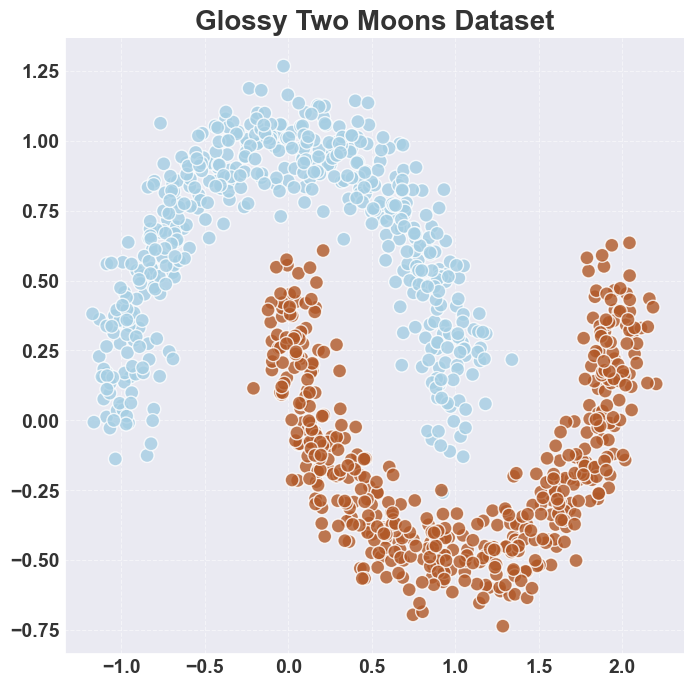

In [44]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons


data, labels = make_moons(n_samples=1000, noise=0.1, random_state=0)

plt.figure(figsize=(8, 8))


plt.scatter(data[:, 0], data[:, 1], c=labels, cmap=plt.cm.Paired, edgecolors='w', s=100, alpha=0.8)


plt.grid(True, linestyle='--', alpha=0.5)


plt.title("Glossy Two Moons Dataset", fontsize=20, weight='bold', color='#333')
plt.xticks(fontsize=14, weight='bold', color='#333')
plt.yticks(fontsize=14, weight='bold', color='#333')


plt.gca().spines['top'].set_visible(True)
plt.gca().spines['right'].set_visible(True)
plt.gca().spines['bottom'].set_linewidth(2)
plt.gca().spines['left'].set_linewidth(2)

# Show the plot
plt.show()


In [49]:
import tensorflow as tf
from tensorflow.keras import layers, Sequential
from tensorflow.keras.optimizers import Adam
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons
import csv
import os

# Custom Sine Activation Layer
class SineActivation(tf.keras.layers.Layer):
    def __init__(self, initial_frequency, **kwargs):
        super().__init__(**kwargs)
        self.initial_frequency = initial_frequency
    
    def build(self, input_shape):
        self.freq = self.add_weight(shape=(), 
                                    initializer=tf.keras.initializers.Constant(self.initial_frequency),
                                    trainable=True, 
                                    name='freq')
    
    def call(self, inputs):
        return tf.math.sin(self.freq * inputs)

def generate_two_moons_dataset(samples, noise=0.1):
    data, labels = make_moons(n_samples=samples, noise=noise, random_state=0)
    return data, labels

# Parameters
samples = 1000
X, y = generate_two_moons_dataset(samples)

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

def create_model(activation, hidden_units, k_values, initializer):
    model = Sequential([layers.Input(shape=(2,))])
    
    sine_layers_k = []  
    for i, units in enumerate(hidden_units):
        if activation == 'sine':
            dense_layer = layers.Dense(units, 
                                       kernel_initializer=initializer, 
                                       bias_initializer=initializer, 
                                       name=f'dense_{i}')
            model.add(dense_layer)
            sine_activation_layer = SineActivation(initial_frequency=k_values[i], name=f'sine_{i}')
            model.add(sine_activation_layer)
            sine_layers_k.append(sine_activation_layer)
        else:
            model.add(layers.Dense(units, 
                                   activation=activation, 
                                   kernel_initializer=initializer, 
                                   bias_initializer=initializer, 
                                   name=f'dense_{i}'))
    

    model.add(layers.Dense(2, 
                           activation='softmax', 
                           kernel_initializer=initializer, 
                           bias_initializer=initializer, 
                           name='output'))
    return model, sine_layers_k


def train_step(model, x_batch, y_batch, optimizer_main, optimizer_k):
    with tf.GradientTape() as tape:
        predictions = model(x_batch, training=True)
        y_batch = tf.reshape(y_batch, (-1, 1))
        loss = tf.keras.losses.sparse_categorical_crossentropy(y_batch, predictions)
        loss = tf.reduce_mean(loss)  
    
    grads = tape.gradient(loss, model.trainable_variables)
    
    k_vars = [v for v in model.trainable_variables if 'freq' in v.name]
    other_vars = [v for v in model.trainable_variables if 'freq' not in v.name]
    
    k_grads = [g for g, v in zip(grads, model.trainable_variables) if 'freq' in v.name]
    other_grads = [g for g, v in zip(grads, model.trainable_variables) if 'freq' not in v.name]
    
    optimizer_k.apply_gradients(zip(k_grads, k_vars))
    optimizer_main.apply_gradients(zip(other_grads, other_vars))
    
    return loss

def run_experiment(initializer_name, initializer):
    H = [2,1]
    K = [1.6,1.6] 
    learning_rate_main = 0.001
    learning_rate_k = 0.01
    epochs = 30
    batch_size = 32


    model, sine_layers_k = create_model('sine', H, K, initializer)


    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    optimizer_main = Adam(learning_rate=learning_rate_main)
    optimizer_k = Adam(learning_rate=learning_rate_k)

    for epoch in range(epochs):
        total_loss = 0.0
        num_batches = 0
        for i in range(0, len(X_train), batch_size):
            x_batch = X_train[i:i+batch_size]
            y_batch = y_train[i:i+batch_size]
            
            batch_loss = train_step(model, x_batch, y_batch, optimizer_main, optimizer_k)
            total_loss += batch_loss.numpy()
            num_batches += 1
        
        avg_loss = total_loss / num_batches
        
        if epoch % 10 == 0:
            test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
            print(f"Initializer: {initializer_name}, Epoch {epoch+1}/{epochs}, Avg Loss: {avg_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
    print(f"Initializer: {initializer_name}, Final Test Accuracy: {test_accuracy:.4f}")

    num_params = model.count_params()
    
    save_results_to_csv(
        test_accuracy=test_accuracy,
        num_params=num_params,
        activation='sine',
        initializer=initializer_name,
        dataset_name='Two Moons'
    )
    
    for i, layer in enumerate(sine_layers_k):
        print(f"Initializer: {initializer_name}, Layer {i+1} - Initial k: {K[i]}, Final k: {layer.freq.numpy():.4f}")
    
    return test_accuracy

def save_results_to_csv(test_accuracy, num_params, activation, initializer, dataset_name):
    csv_filename = 'experiment_results.csv'
    headers = ['Test Accuracy', 'Number of Parameters', 'Activation', 'Initializer', 'Dataset']

    row = [test_accuracy, num_params, activation, initializer, dataset_name]

    file_exists = os.path.isfile(csv_filename)
    
    with open(csv_filename, mode='a', newline='') as file:
        writer = csv.writer(file)
        
        if not file_exists:
            writer.writerow(headers)
        
        writer.writerow(row)

# Define initializers
initializers = {
    'xavier': tf.keras.initializers.GlorotUniform(),
    'he': tf.keras.initializers.HeNormal(),
    'lecun': tf.keras.initializers.LecunUniform(),
    'random': tf.keras.initializers.RandomUniform(minval=-1.5, maxval=1.5),
    'uniform': tf.keras.initializers.RandomUniform(minval=-1.5, maxval=1.5)
}

# Run experiments for each initializer
results = {}
for name, initializer in initializers.items():
    print(f"\nRunning experiment with {name} initializer...")
    accuracy = run_experiment(name, initializer)
    results[name] = accuracy

print("\nSummary of Results:")
for name, accuracy in results.items():
    print(f"{name} initializer: {accuracy:.4f}")

best_initializer = max(results, key=results.get)
print(f"\nBest initializer: {best_initializer} with accuracy {results[best_initializer]:.4f}")



Running experiment with xavier initializer...
Initializer: xavier, Epoch 1/30, Avg Loss: 0.4902, Test Accuracy: 0.8150
Initializer: xavier, Epoch 11/30, Avg Loss: 0.2514, Test Accuracy: 0.8150
Initializer: xavier, Epoch 21/30, Avg Loss: 0.2417, Test Accuracy: 0.8150
Initializer: xavier, Final Test Accuracy: 0.8150
Initializer: xavier, Layer 1 - Initial k: 1.6, Final k: 0.9600
Initializer: xavier, Layer 2 - Initial k: 1.6, Final k: 1.6619

Running experiment with he initializer...
Initializer: he, Epoch 1/30, Avg Loss: 0.8378, Test Accuracy: 0.4850
Initializer: he, Epoch 11/30, Avg Loss: 0.1978, Test Accuracy: 0.9550
Initializer: he, Epoch 21/30, Avg Loss: 0.1657, Test Accuracy: 0.9600
Initializer: he, Final Test Accuracy: 0.9650
Initializer: he, Layer 1 - Initial k: 1.6, Final k: 1.5074
Initializer: he, Layer 2 - Initial k: 1.6, Final k: 2.4993

Running experiment with lecun initializer...
Initializer: lecun, Epoch 1/30, Avg Loss: 0.7865, Test Accuracy: 0.7500
Initializer: lecun, Epoc

In [50]:
import tensorflow as tf
from tensorflow.keras import layers, Sequential
from tensorflow.keras.optimizers import Adam
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons
import csv
import os


def mish(x):
    return x * tf.math.tanh(tf.math.softplus(x))


def generate_two_moons_dataset(samples, noise=0.1):
    data, labels = make_moons(n_samples=samples, noise=noise, random_state=0)
    return data, labels


samples = 1000
X, y = generate_two_moons_dataset(samples)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

def create_model(activation, hidden_units, initializer):
    model = Sequential([layers.Input(shape=(2,))])
    
    for i, units in enumerate(hidden_units):
        model.add(layers.Dense(units, 
                               kernel_initializer=initializer, 
                               bias_initializer=initializer, 
                               name=f'dense_{i}'))
        if activation == 'mish':
            model.add(layers.Activation(mish))
        else:
            model.add(layers.Activation(activation))
    

    model.add(layers.Dense(2, 
                           activation='softmax', 
                           kernel_initializer=initializer, 
                           bias_initializer=initializer, 
                           name='output'))
    return model

def run_experiment(activation, initializer_name, initializer, dataset_name):

    H = [2,1]
    learning_rate = 0.001
    epochs = 30
    batch_size = 32

    model = create_model(activation, H, initializer)


    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])


    history = model.fit(X_train, y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_split=0.2,
                        verbose=0)


    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
    num_params = model.count_params()
    
    print(f"Activation: {activation}, Initializer: {initializer_name}, Final Test Accuracy: {test_accuracy:.4f}, Num Params: {num_params}")
    

    save_results_to_csv(test_accuracy, num_params, activation, initializer_name, dataset_name)
    
    return test_accuracy

def save_results_to_csv(test_accuracy, num_params, activation, weight_init, dataset):
    csv_filename = 'experiment_results.csv'
    headers = ['test_accuracy', 'num_params', 'activation', 'weight_init', 'dataset']

    row = [test_accuracy, num_params, activation, weight_init, dataset]

    file_exists = os.path.isfile(csv_filename)
    
    with open(csv_filename, mode='a', newline='') as file:
        writer = csv.writer(file)
        
        if not file_exists:
            writer.writerow(headers)
        
        writer.writerow(row)


activations = ['relu', 'leaky_relu', 'elu', 'softplus', 'swish', 'mish', 'gelu']
initializers = {
    'xavier': tf.keras.initializers.GlorotUniform(),
    'he': tf.keras.initializers.HeNormal(),
    'lecun': tf.keras.initializers.LecunUniform(),
    'random': tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05),
    'uniform': tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05)
}


dataset_name = 'Two Moons'


results = {}
for activation in activations:
    for init_name, initializer in initializers.items():
        print(f"\nRunning experiment with {activation} activation and {init_name} initializer...")
        accuracy = run_experiment(activation, init_name, initializer, dataset_name)
        results[(activation, init_name)] = accuracy


print("\nSummary of Results:")
for (activation, init_name), accuracy in results.items():
    print(f"{activation} activation with {init_name} initializer: {accuracy:.4f}")


best_combo = max(results, key=results.get)
print(f"\nBest combination: {best_combo[0]} activation with {best_combo[1]} initializer, accuracy: {results[best_combo]:.4f}")



Running experiment with relu activation and xavier initializer...
Activation: relu, Initializer: xavier, Final Test Accuracy: 0.6550, Num Params: 13

Running experiment with relu activation and he initializer...
Activation: relu, Initializer: he, Final Test Accuracy: 0.4700, Num Params: 13

Running experiment with relu activation and lecun initializer...
Activation: relu, Initializer: lecun, Final Test Accuracy: 0.7400, Num Params: 13

Running experiment with relu activation and random initializer...
Activation: relu, Initializer: random, Final Test Accuracy: 0.5300, Num Params: 13

Running experiment with relu activation and uniform initializer...
Activation: relu, Initializer: uniform, Final Test Accuracy: 0.7800, Num Params: 13

Running experiment with leaky_relu activation and xavier initializer...
Activation: leaky_relu, Initializer: xavier, Final Test Accuracy: 0.6550, Num Params: 13

Running experiment with leaky_relu activation and he initializer...
Activation: leaky_relu, Ini